https://www.kaggle.com/c/jigsaw-unintended-bias-in-toxicity-classification/data         
https://www.kaggle.com/c/jigsaw-toxic-comment-classification-challenge/data          
https://www.kaggle.com/tunguz/logistic-regression-with-words-and-char-n-grams         

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

In [2]:
import re, string, nltk
from scipy.sparse import vstack
from nltk.tokenize import word_tokenize
from wordcloud import WordCloud

In [21]:
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, precision_recall_curve, roc_auc_score
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import resample
from scipy.spatial.distance import cdist
from yellowbrick.cluster import KElbowVisualizer

In [7]:
pd.set_option('display.max_columns', 50)

In [5]:
def downsampling(features, target):
    labels = []
    idx = np.where(target.values==1)[0]
    A = [features[i] for i in idx]
    l = idx.shape[0]
    labels += [1]*l

    idx = np.where(target.values==0)[0]
    idx = np.random.choice(idx, l)
    B = [features[i] for i in idx]

    features = A + B
    labels += [0]*l
    labels = np.array(labels)    
    
    return features, labels

In [6]:
def upsampling(features, targets):
    
    labels = []
    idx = np.where(target.values==0)[0]
    A = [features[i] for i in idx]
    l = idx.shape[0]
    labels += [0]*l

    idx = np.where(target.values==1)[0]
    idx = np.random.choice(idx, l)
    B = [features[i] for i in idx]

    features = A + B
    labels += [1]*l
    labels = np.array(labels)   
    
    return features, labels

In [7]:
def predict(model, X_test, y_test):
    pred = model.predict(X_test)

    precision = precision_score(pred,y_test,average=None), precision_score(pred,y_test)
    recall = recall_score(pred,y_test,average=None), recall_score(pred,y_test)
    f1 = f1_score(pred,y_test,average=None), f1_score(pred,y_test)
    accuracy = accuracy_score(pred,y_test)
    roc = roc_auc_score(pred, y_test)

    print('precision:',precision,
      '\nrecall:',recall,'\nf1:',f1,'\nacc:',accuracy,'\nroc:',roc)

## Load Data

In [8]:
df = pd.read_csv('toxicity/train.csv')
print(df.shape)
df.head(1)

(1804874, 45)


,id,target,comment_text,severe_toxicity,obscene,identity_attack,insult,threat,asian,atheist,bisexual,black,buddhist,christian,female,heterosexual,hindu,homosexual_gay_or_lesbian,intellectual_or_learning_disability,jewish,latino,male,muslim,other_disability,other_gender,other_race_or_ethnicity,other_religion,other_sexual_orientation,physical_disability,psychiatric_or_mental_illness,transgender,white,created_date,publication_id,parent_id,article_id,rating,funny,wow,sad,likes,disagree,sexual_explicit,identity_annotator_count,toxicity_annotator_count
0,59848,0.0,"This is so cool. It's like, 'would you want yo...",0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2015-09-29 10:50:41.987077+00,2,NaN,2006,rejected,0,0,0,0,0,0.0,0,4


In [9]:
data = df['comment_text'].values

# Preprocess - With Punct, Lemma

1\. Tokenize        
2\. Lower        
3\. Lemmatize        
4\. Encode        
* How to deal with punctuation?      
* Analyze if lemmatizer or stemmer is better?

In [10]:
stopwords = nltk.corpus.stopwords.words('english')
punctuation = '["#$%&\'()+,-./:;<=>@[\\]^_`{|}~]'
ps = nltk.PorterStemmer()
wn = nltk.WordNetLemmatizer()

In [11]:
def clean_text(comment):
    comment = re.sub(punctuation, '', comment)
    comment = ' '.join([wn.lemmatize(token) for token in word_tokenize(comment.lower()) if token not in stopwords])
    return comment

In [12]:
features = []
for i,row in enumerate(data):
    features += [clean_text(row)]
    
    if i % 100000 == 0: print(i)
        
features = np.array(features)

0
100000
200000
300000
400000
500000
600000
700000
800000
900000
1000000
1100000
1200000
1300000
1400000
1500000
1600000
1700000
1800000


## 0. Target

In [25]:
target = df['target'].apply(lambda x: 1 if x >0 else 0)
target.value_counts()

0    1264764
1     540110
Name: target, dtype: int64

In [14]:
down_sampled_features, down_labels = downsampling(features, target)
up_sampled_features, up_labels = upsampling(features, target)

In [15]:
#downsample
model = TfidfVectorizer(sublinear_tf=True, min_df=5).fit(down_sampled_features)
tfidf_features = model.transform(down_sampled_features)
X_train, X_test, y_train, y_test = train_test_split(tfidf_features, down_labels, test_size=0.2, random_state=42)

clf = LogisticRegression().fit(X_train, y_train)
predict(clf, X_test, y_test)

/Users/osamaqureshi/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


precision: (array([0.82646134, 0.70446796]), 0.7044679589340647) 
recall: (array([0.73695279, 0.80206136]), 0.8020613553886404) 
f1: (array([0.7791448 , 0.75010359]), 0.7501035932042857) 
acc: 0.7655199866693821 
roc: 0.7695070739599488


In [16]:
# rf = RandomForestClassifier().fit(X_train, y_train)
# predict(rf, X_test, y_test)

In [17]:
#upsample
model = TfidfVectorizer(sublinear_tf=True, min_df=5).fit(up_sampled_features)
tfidf_features = model.transform(up_sampled_features)
X_train, X_test, y_train, y_test = train_test_split(tfidf_features, up_labels, test_size=0.2, random_state=42)

clf = LogisticRegression().fit(X_train, y_train)
predict(clf, X_test, y_test)

/Users/osamaqureshi/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


precision: (array([0.83313238, 0.72149412]), 0.7214941151819213) 
recall: (array([0.74948435, 0.81214565]), 0.8121456480912838) 
f1: (array([0.78909779, 0.76414073]), 0.7641407321336977) 
acc: 0.7773163393990188 
roc: 0.7808150004325551


In [18]:
# rf = RandomForestClassifier().fit(X_train, y_train)
# predict(rf, X_test, y_test)

In [19]:
# no sampling
model = TfidfVectorizer(sublinear_tf=True, min_df=5).fit(features)
tfidf_features = model.transform(features)
X_train, X_test, y_train, y_test = train_test_split(tfidf_features, target, test_size=0.2, random_state=42)

clf = LogisticRegression().fit(X_train, y_train)
predict(clf, X_test, y_test)

/Users/osamaqureshi/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


precision: (array([0.93574335, 0.51008176]), 0.5100817589216661) 
recall: (array([0.81610669, 0.77357331]), 0.7735733135987266) 
f1: (array([0.87183993, 0.61478452]), 0.6147845241331861) 
acc: 0.8076681210610153 
roc: 0.7948400024818743


In [20]:
# rf = RandomForestClassifier().fit(X_train, y_train)
# predict(rf, X_test, y_test)

## 1. severe_toxic

In [21]:
target = df['severe_toxicity'].apply(lambda x: 1 if x >0 else 0)
target.value_counts()

0    1700238
1     104636
Name: severe_toxicity, dtype: int64

In [22]:
down_sampled_features, down_labels = downsampling(features, target)
up_sampled_features, up_labels = upsampling(features, target)

In [23]:
#downsample
model = TfidfVectorizer(sublinear_tf=True, min_df=5).fit(down_sampled_features)
tfidf_features = model.transform(down_sampled_features)
X_train, X_test, y_train, y_test = train_test_split(tfidf_features, down_labels, test_size=0.2, random_state=42)

clf = LogisticRegression().fit(X_train, y_train)
predict(clf, X_test, y_test)

/Users/osamaqureshi/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


precision: (array([0.8548795 , 0.75784689]), 0.7578468899521531) 
recall: (array([0.77971708, 0.83893008]), 0.8389300847457627) 
f1: (array([0.81557023, 0.79632981]), 0.7963298139768727) 
acc: 0.8064269501851631 
roc: 0.8093235842662436


In [24]:
# rf = RandomForestClassifier().fit(X_train, y_train)
# predict(rf, X_test, y_test)

In [25]:
#upsample
model = TfidfVectorizer(sublinear_tf=True, min_df=5).fit(up_sampled_features)
tfidf_features = model.transform(up_sampled_features)
X_train, X_test, y_train, y_test = train_test_split(tfidf_features, up_labels, test_size=0.2, random_state=42)

clf = LogisticRegression().fit(X_train, y_train)
predict(clf, X_test, y_test)

/Users/osamaqureshi/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


precision: (array([0.87889782, 0.84796011]), 0.8479601141277171) 
recall: (array([0.85258039, 0.87498141]), 0.8749814095929536) 
f1: (array([0.8655391 , 0.86125887]), 0.86125887120747) 
acc: 0.8634325154095892 
roc: 0.8637809008749082


In [26]:
# rf = RandomForestClassifier().fit(X_train, y_train)
# predict(rf, X_test, y_test)

In [27]:
# no sampling
model = TfidfVectorizer(sublinear_tf=True, min_df=5).fit(features)
tfidf_features = model.transform(features)
X_train, X_test, y_train, y_test = train_test_split(tfidf_features, target, test_size=0.2, random_state=42)

clf = LogisticRegression().fit(X_train, y_train)
predict(clf, X_test, y_test)

/Users/osamaqureshi/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


precision: (array([0.99331335, 0.282931  ]), 0.2829310017107014) 
recall: (array([0.95722159, 0.7237146 ]), 0.7237145982739759) 
f1: (array([0.97493356, 0.40681904]), 0.4068190359058454) 
acc: 0.9518997160468177 
roc: 0.8404680921110089


In [28]:
# rf = RandomForestClassifier().fit(X_train, y_train)
# predict(rf, X_test, y_test)

## 2. obscene

In [29]:
target = df['obscene'].apply(lambda x: 1 if x >0 else 0)
target.value_counts()

0    1657699
1     147175
Name: obscene, dtype: int64

In [30]:
down_sampled_features, down_labels = downsampling(features, target)
up_sampled_features, up_labels = upsampling(features, target)

In [31]:
#downsample
model = TfidfVectorizer(sublinear_tf=True, min_df=5).fit(down_sampled_features)
tfidf_features = model.transform(down_sampled_features)
X_train, X_test, y_train, y_test = train_test_split(tfidf_features, down_labels, test_size=0.2, random_state=42)

clf = LogisticRegression().fit(X_train, y_train)
predict(clf, X_test, y_test)

/Users/osamaqureshi/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


precision: (array([0.87794955, 0.74994893]), 0.7499489344318104) 
recall: (array([0.77903794, 0.85953412]), 0.8595341215029849) 
f1: (array([0.82554155, 0.80101085]), 0.8010108539534206) 
acc: 0.8140818753184984 
roc: 0.8192860282915785


In [32]:
# rf = RandomForestClassifier().fit(X_train, y_train)
# predict(rf, X_test, y_test)

In [33]:
#upsample
model = TfidfVectorizer(sublinear_tf=True, min_df=5).fit(up_sampled_features)
tfidf_features = model.transform(up_sampled_features)
X_train, X_test, y_train, y_test = train_test_split(tfidf_features, up_labels, test_size=0.2, random_state=42)

clf = LogisticRegression().fit(X_train, y_train)
predict(clf, X_test, y_test)

/Users/osamaqureshi/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


precision: (array([0.89782498, 0.82679049]), 0.8267904924908999) 
recall: (array([0.83801317, 0.89020323]), 0.890203228820598) 
f1: (array([0.86688861, 0.85732587]), 0.8573258676931922) 
acc: 0.8622730288954575 
roc: 0.864108197362257


In [34]:
# rf = RandomForestClassifier().fit(X_train, y_train)
# predict(rf, X_test, y_test)

In [35]:
# no sampling
model = TfidfVectorizer(sublinear_tf=True, min_df=5).fit(features)
tfidf_features = model.transform(features)
X_train, X_test, y_train, y_test = train_test_split(tfidf_features, target, test_size=0.2, random_state=42)

clf = LogisticRegression().fit(X_train, y_train)
predict(clf, X_test, y_test)

/Users/osamaqureshi/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


precision: (array([0.99118142, 0.39572716]), 0.395727159202133) 
recall: (array([0.94830334, 0.80050522]), 0.8005052229125418) 
f1: (array([0.96926841, 0.52963231]), 0.5296323064414129) 
acc: 0.9423062538956991 
roc: 0.8744042827043362


In [36]:
# rf = RandomForestClassifier().fit(X_train, y_train)
# predict(rf, X_test, y_test)

## 3. threat

In [37]:
target = df['threat'].apply(lambda x: 1 if x >0 else 0)
target.value_counts()

0    1697945
1     106929
Name: threat, dtype: int64

In [38]:
down_sampled_features, down_labels = downsampling(features, target)
up_sampled_features, up_labels = upsampling(features, target)

In [39]:
#downsample
model = TfidfVectorizer(sublinear_tf=True, min_df=5).fit(down_sampled_features)
tfidf_features = model.transform(down_sampled_features)
X_train, X_test, y_train, y_test = train_test_split(tfidf_features, down_labels, test_size=0.2, random_state=42)

clf = LogisticRegression().fit(X_train, y_train)
predict(clf, X_test, y_test)

/Users/osamaqureshi/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


precision: (array([0.82975439, 0.71757723]), 0.7175772304528673) 
recall: (array([0.7458682, 0.8084031]), 0.8084030958774285) 
f1: (array([0.78557824, 0.7602872 ]), 0.7602871998019312) 
acc: 0.773636958758066 
roc: 0.7771356494568605


In [40]:
# rf = RandomForestClassifier().fit(X_train, y_train)
# predict(rf, X_test, y_test)

In [41]:
#upsample
model = TfidfVectorizer(sublinear_tf=True, min_df=5).fit(up_sampled_features)
tfidf_features = model.transform(up_sampled_features)
X_train, X_test, y_train, y_test = train_test_split(tfidf_features, up_labels, test_size=0.2, random_state=42)

clf = LogisticRegression().fit(X_train, y_train)
predict(clf, X_test, y_test)

/Users/osamaqureshi/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


precision: (array([0.85050694, 0.81832455]), 0.8183245456419924) 
recall: (array([0.82407355, 0.84545975]), 0.8454597466782716) 
f1: (array([0.83708161, 0.83167087]), 0.8316708677351949) 
acc: 0.8344204317572124 
roc: 0.834766646266594


In [42]:
# rf = RandomForestClassifier().fit(X_train, y_train)
# predict(rf, X_test, y_test)

In [43]:
# no sampling
model = TfidfVectorizer(sublinear_tf=True, min_df=5).fit(features)
tfidf_features = model.transform(features)
X_train, X_test, y_train, y_test = train_test_split(tfidf_features, target, test_size=0.2, random_state=42)

clf = LogisticRegression().fit(X_train, y_train)
predict(clf, X_test, y_test)

/Users/osamaqureshi/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


precision: (array([0.99341243, 0.16289215]), 0.16289214776313346) 
recall: (array([0.94922149, 0.61085973]), 0.6108597285067874) 
f1: (array([0.97081433, 0.25719938]), 0.2571993844801055) 
acc: 0.9438354456679825 
roc: 0.7800406083086369


In [44]:
# rf = RandomForestClassifier().fit(X_train, y_train)
# predict(rf, X_test, y_test)

## 4. insult

In [45]:
target = df['insult'].apply(lambda x: 1 if x >0 else 0)
target.value_counts()

0    1350335
1     454539
Name: insult, dtype: int64

In [46]:
down_sampled_features, down_labels = downsampling(features, target)
up_sampled_features, up_labels = upsampling(features, target)

In [47]:
#downsample
model = TfidfVectorizer(sublinear_tf=True, min_df=5).fit(down_sampled_features)
tfidf_features = model.transform(down_sampled_features)
X_train, X_test, y_train, y_test = train_test_split(tfidf_features, down_labels, test_size=0.2, random_state=42)

clf = LogisticRegression().fit(X_train, y_train)
predict(clf, X_test, y_test)

/Users/osamaqureshi/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


precision: (array([0.83989403, 0.72175684]), 0.7217568385711927) 
recall: (array([0.75141371, 0.81823968]), 0.818239676537756) 
f1: (array([0.79319402, 0.76697587]), 0.7669758682403583) 
acc: 0.7808663703964448 
roc: 0.7848266919218977


In [48]:
# rf = RandomForestClassifier().fit(X_train, y_train)
# predict(rf, X_test, y_test)

In [49]:
#upsample
model = TfidfVectorizer(sublinear_tf=True, min_df=5).fit(up_sampled_features)
tfidf_features = model.transform(up_sampled_features)
X_train, X_test, y_train, y_test = train_test_split(tfidf_features, up_labels, test_size=0.2, random_state=42)

clf = LogisticRegression().fit(X_train, y_train)
predict(clf, X_test, y_test)

/Users/osamaqureshi/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


precision: (array([0.84495963, 0.74366034]), 0.7436603353278346) 
recall: (array([0.76700603, 0.82766985]), 0.8276698529320917) 
f1: (array([0.80409794, 0.78341935]), 0.78341935383272) 
acc: 0.794276975713434 
roc: 0.7973379417256474


In [50]:
# rf = RandomForestClassifier().fit(X_train, y_train)
# predict(rf, X_test, y_test)

In [51]:
# no sampling
model = TfidfVectorizer(sublinear_tf=True, min_df=5).fit(features)
tfidf_features = model.transform(features)
X_train, X_test, y_train, y_test = train_test_split(tfidf_features, target, test_size=0.2, random_state=42)

clf = LogisticRegression().fit(X_train, y_train)
predict(clf, X_test, y_test)

/Users/osamaqureshi/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


precision: (array([0.95297012, 0.49362897]), 0.4936289723302881) 
recall: (array([0.8471387 , 0.78091073]), 0.78091072539935) 
f1: (array([0.89694341, 0.60489314]), 0.6048931383577053) 
acc: 0.8365260752129648 
roc: 0.814024710605366


In [52]:
# rf = RandomForestClassifier().fit(X_train, y_train)
# predict(rf, X_test, y_test)

## 5. identity_attack

In [53]:
target = df['identity_attack'].apply(lambda x: 1 if x >0 else 0)
target.value_counts()

0    1586322
1     218552
Name: identity_attack, dtype: int64

In [54]:
down_sampled_features, down_labels = downsampling(features, target)
up_sampled_features, up_labels = upsampling(features, target)

In [55]:
#downsample
model = TfidfVectorizer(sublinear_tf=True, min_df=5).fit(down_sampled_features)
tfidf_features = model.transform(down_sampled_features)
X_train, X_test, y_train, y_test = train_test_split(tfidf_features, down_labels, test_size=0.2, random_state=42)

clf = LogisticRegression().fit(X_train, y_train)
predict(clf, X_test, y_test)

/Users/osamaqureshi/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


precision: (array([0.83483806, 0.75424777]), 0.7542477673460041) 
recall: (array([0.77290137, 0.82008764]), 0.8200876406732397) 
f1: (array([0.80267669, 0.78579097]), 0.7857909678650666) 
acc: 0.7945802495967788 
roc: 0.796494504891289


In [56]:
# rf = RandomForestClassifier().fit(X_train, y_train)
# predict(rf, X_test, y_test)

In [57]:
#upsample
model = TfidfVectorizer(sublinear_tf=True, min_df=5).fit(up_sampled_features)
tfidf_features = model.transform(up_sampled_features)
X_train, X_test, y_train, y_test = train_test_split(tfidf_features, up_labels, test_size=0.2, random_state=42)

clf = LogisticRegression().fit(X_train, y_train)
predict(clf, X_test, y_test)

/Users/osamaqureshi/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


precision: (array([0.84651333, 0.80416245]), 0.8041624471176142) 
recall: (array([0.81239574, 0.83948149]), 0.8394814929472634) 
f1: (array([0.8291037, 0.8214425]), 0.8214424976394498) 
acc: 0.8253570758783286 
roc: 0.8259386140300253


In [58]:
# rf = RandomForestClassifier().fit(X_train, y_train)
# predict(rf, X_test, y_test)

In [59]:
# no sampling
model = TfidfVectorizer(sublinear_tf=True, min_df=5).fit(features)
tfidf_features = model.transform(features)
X_train, X_test, y_train, y_test = train_test_split(tfidf_features, target, test_size=0.2, random_state=42)

clf = LogisticRegression().fit(X_train, y_train)
predict(clf, X_test, y_test)

/Users/osamaqureshi/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


precision: (array([0.97983395, 0.33689742]), 0.336897422481061) 
recall: (array([0.91421331, 0.69847184]), 0.6984718422790303) 
f1: (array([0.9458869 , 0.45454964]), 0.45454964011111276) 
acc: 0.9015416580095574 
roc: 0.8063425776425333


In [60]:
# rf = RandomForestClassifier().fit(X_train, y_train)
# predict(rf, X_test, y_test)

# Preprocess - No Punct, Lemma

1\. Tokenize        
2\. Lower        
3\. Lemmatize        
4\. Encode        
* How to deal with punctuation?      
* Analyze if lemmatizer or stemmer is better?

In [61]:
stopwords = nltk.corpus.stopwords.words('english')
punctuation = '["!?#$%&\'()+,-./:;<=>@[\\]^_`{|}~]'
wn = nltk.WordNetLemmatizer()

In [62]:
def clean_text(comment):
    comment = re.sub(punctuation, '', comment)
    comment = ' '.join([ps.stem(token) for token in word_tokenize(comment.lower()) if token not in stopwords])
    return comment

In [63]:
features = []
for i,row in enumerate(data):
    features += [clean_text(row)]
    
    if i % 100000 == 0: print(i)
        
features = np.array(features)

0
100000
200000
300000
400000
500000
600000
700000
800000
900000
1000000
1100000
1200000
1300000
1400000
1500000
1600000
1700000
1800000


## 0. Target

In [ ]:
target = df['target'].apply(lambda x: 1 if x >0 else 0)
target.value_counts()

In [ ]:
down_sampled_features, down_labels = downsampling(features, target)
up_sampled_features, up_labels = upsampling(features, target)

In [ ]:
#downsample
model = TfidfVectorizer(sublinear_tf=True, min_df=5).fit(down_sampled_features)
tfidf_features = model.transform(down_sampled_features)
X_train, X_test, y_train, y_test = train_test_split(tfidf_features, down_labels, test_size=0.2, random_state=42)

clf = LogisticRegression().fit(X_train, y_train)
predict(clf, X_test, y_test)

In [ ]:
#upsample
model = TfidfVectorizer(sublinear_tf=True, min_df=5).fit(up_sampled_features)
tfidf_features = model.transform(up_sampled_features)
X_train, X_test, y_train, y_test = train_test_split(tfidf_features, up_labels, test_size=0.2, random_state=42)

clf = LogisticRegression().fit(X_train, y_train)
rf = RandomForestClassifier().fit(X_train, y_train)

predict(clf, X_test, y_test)
predict(rf, X_test, y_test)

In [ ]:
# no sampling
model = TfidfVectorizer(sublinear_tf=True, min_df=5).fit(features)
tfidf_features = model.transform(features)
X_train, X_test, y_train, y_test = train_test_split(tfidf_features, target, test_size=0.2, random_state=42)

clf = LogisticRegression().fit(X_train, y_train)
rf = RandomForestClassifier().fit(X_train, y_train)

predict(clf, X_test, y_test)
predict(rf, X_test, y_test)

## 1. severe_toxic

In [ ]:
target = df['severe_toxicity'].apply(lambda x: 1 if x >0 else 0)
target.value_counts()

In [ ]:
down_sampled_features, down_labels = downsampling(features, target)
up_sampled_features, up_labels = upsampling(features, target)

In [ ]:
#downsample
model = TfidfVectorizer(sublinear_tf=True, min_df=5).fit(down_sampled_features)
tfidf_features = model.transform(down_sampled_features)
X_train, X_test, y_train, y_test = train_test_split(tfidf_features, down_labels, test_size=0.2, random_state=42)

clf = LogisticRegression().fit(X_train, y_train)
rf = RandomForestClassifier().fit(X_train, y_train)
predict(clf, X_test, y_test)
predict(rf, X_test, y_test)

In [ ]:
#upsample
model = TfidfVectorizer(sublinear_tf=True, min_df=5).fit(up_sampled_features)
tfidf_features = model.transform(up_sampled_features)
X_train, X_test, y_train, y_test = train_test_split(tfidf_features, up_labels, test_size=0.2, random_state=42)

clf = LogisticRegression().fit(X_train, y_train)
rf = RandomForestClassifier().fit(X_train, y_train)

predict(clf, X_test, y_test)
predict(rf, X_test, y_test)

In [ ]:
# no sampling
model = TfidfVectorizer(sublinear_tf=True, min_df=5).fit(features)
tfidf_features = model.transform(features)
X_train, X_test, y_train, y_test = train_test_split(tfidf_features, target, test_size=0.2, random_state=42)

clf = LogisticRegression().fit(X_train, y_train)
rf = RandomForestClassifier().fit(X_train, y_train)

predict(clf, X_test, y_test)
predict(rf, X_test, y_test)

## 2. obscene

In [ ]:
target = df['obscene'].apply(lambda x: 1 if x >0 else 0)
target.value_counts()

In [ ]:
down_sampled_features, down_labels = downsampling(features, target)
up_sampled_features, up_labels = upsampling(features, target)

In [ ]:
#downsample
model = TfidfVectorizer(sublinear_tf=True, min_df=5).fit(down_sampled_features)
tfidf_features = model.transform(down_sampled_features)
X_train, X_test, y_train, y_test = train_test_split(tfidf_features, down_labels, test_size=0.2, random_state=42)

clf = LogisticRegression().fit(X_train, y_train)
rf = RandomForestClassifier().fit(X_train, y_train)
predict(clf, X_test, y_test)
predict(rf, X_test, y_test)

In [ ]:
#upsample
model = TfidfVectorizer(sublinear_tf=True, min_df=5).fit(up_sampled_features)
tfidf_features = model.transform(up_sampled_features)
X_train, X_test, y_train, y_test = train_test_split(tfidf_features, up_labels, test_size=0.2, random_state=42)

clf = LogisticRegression().fit(X_train, y_train)
rf = RandomForestClassifier().fit(X_train, y_train)

predict(clf, X_test, y_test)
predict(rf, X_test, y_test)

In [ ]:
# no sampling
model = TfidfVectorizer(sublinear_tf=True, min_df=5).fit(features)
tfidf_features = model.transform(features)
X_train, X_test, y_train, y_test = train_test_split(tfidf_features, target, test_size=0.2, random_state=42)

clf = LogisticRegression().fit(X_train, y_train)
rf = RandomForestClassifier().fit(X_train, y_train)

predict(clf, X_test, y_test)
predict(rf, X_test, y_test)

## 3. threat

In [ ]:
target = df['threat'].apply(lambda x: 1 if x >0 else 0)
target.value_counts()

In [ ]:
down_sampled_features, down_labels = downsampling(features, target)
up_sampled_features, up_labels = upsampling(features, target)

In [ ]:
#downsample
model = TfidfVectorizer(sublinear_tf=True, min_df=5).fit(down_sampled_features)
tfidf_features = model.transform(down_sampled_features)
X_train, X_test, y_train, y_test = train_test_split(tfidf_features, down_labels, test_size=0.2, random_state=42)

clf = LogisticRegression().fit(X_train, y_train)
rf = RandomForestClassifier().fit(X_train, y_train)
predict(clf, X_test, y_test)
predict(rf, X_test, y_test)

In [ ]:
#upsample
model = TfidfVectorizer(sublinear_tf=True, min_df=5).fit(up_sampled_features)
tfidf_features = model.transform(up_sampled_features)
X_train, X_test, y_train, y_test = train_test_split(tfidf_features, up_labels, test_size=0.2, random_state=42)

clf = LogisticRegression().fit(X_train, y_train)
rf = RandomForestClassifier().fit(X_train, y_train)

predict(clf, X_test, y_test)
predict(rf, X_test, y_test)

In [ ]:
# no sampling
model = TfidfVectorizer(sublinear_tf=True, min_df=5).fit(features)
tfidf_features = model.transform(features)
X_train, X_test, y_train, y_test = train_test_split(tfidf_features, target, test_size=0.2, random_state=42)

clf = LogisticRegression().fit(X_train, y_train)
rf = RandomForestClassifier().fit(X_train, y_train)

predict(clf, X_test, y_test)
predict(rf, X_test, y_test)

## 4. insult

In [ ]:
target = df['insult'].apply(lambda x: 1 if x >0 else 0)
target.value_counts()

In [ ]:
down_sampled_features, down_labels = downsampling(features, target)
up_sampled_features, up_labels = upsampling(features, target)

In [ ]:
#downsample
model = TfidfVectorizer(sublinear_tf=True, min_df=5).fit(down_sampled_features)
tfidf_features = model.transform(down_sampled_features)
X_train, X_test, y_train, y_test = train_test_split(tfidf_features, down_labels, test_size=0.2, random_state=42)

clf = LogisticRegression().fit(X_train, y_train)
rf = RandomForestClassifier().fit(X_train, y_train)
predict(clf, X_test, y_test)
predict(rf, X_test, y_test)

In [ ]:
#upsample
model = TfidfVectorizer(sublinear_tf=True, min_df=5).fit(up_sampled_features)
tfidf_features = model.transform(up_sampled_features)
X_train, X_test, y_train, y_test = train_test_split(tfidf_features, up_labels, test_size=0.2, random_state=42)

clf = LogisticRegression().fit(X_train, y_train)
rf = RandomForestClassifier().fit(X_train, y_train)

predict(clf, X_test, y_test)
predict(rf, X_test, y_test)

In [ ]:
# no sampling
model = TfidfVectorizer(sublinear_tf=True, min_df=5).fit(features)
tfidf_features = model.transform(features)
X_train, X_test, y_train, y_test = train_test_split(tfidf_features, target, test_size=0.2, random_state=42)

clf = LogisticRegression().fit(X_train, y_train)
rf = RandomForestClassifier().fit(X_train, y_train)

predict(clf, X_test, y_test)
predict(rf, X_test, y_test)

## 5. identity_attack

In [ ]:
target = df['identity_attack'].apply(lambda x: 1 if x >0 else 0)
target.value_counts()

In [ ]:
down_sampled_features, down_labels = downsampling(features, target)
up_sampled_features, up_labels = upsampling(features, target)

In [ ]:
#downsample
model = TfidfVectorizer(sublinear_tf=True, min_df=5).fit(down_sampled_features)
tfidf_features = model.transform(down_sampled_features)
X_train, X_test, y_train, y_test = train_test_split(tfidf_features, down_labels, test_size=0.2, random_state=42)

clf = LogisticRegression().fit(X_train, y_train)
rf = RandomForestClassifier().fit(X_train, y_train)
predict(clf, X_test, y_test)
predict(rf, X_test, y_test)

In [ ]:
#upsample
model = TfidfVectorizer(sublinear_tf=True, min_df=5).fit(up_sampled_features)
tfidf_features = model.transform(up_sampled_features)
X_train, X_test, y_train, y_test = train_test_split(tfidf_features, up_labels, test_size=0.2, random_state=42)

clf = LogisticRegression().fit(X_train, y_train)
rf = RandomForestClassifier().fit(X_train, y_train)

predict(clf, X_test, y_test)
predict(rf, X_test, y_test)

In [ ]:
# no sampling
model = TfidfVectorizer(sublinear_tf=True, min_df=5).fit(features)
tfidf_features = model.transform(features)
X_train, X_test, y_train, y_test = train_test_split(tfidf_features, target, test_size=0.2, random_state=42)

clf = LogisticRegression().fit(X_train, y_train)
rf = RandomForestClassifier().fit(X_train, y_train)

predict(clf, X_test, y_test)
predict(rf, X_test, y_test)

## 0. Target

In [64]:
target = df['target'].apply(lambda x: 1 if x >0 else 0)
target.value_counts()

0    1264764
1     540110
Name: target, dtype: int64

In [65]:
down_sampled_features, down_labels = downsampling(features, target)
up_sampled_features, up_labels = upsampling(features, target)

In [66]:
#downsample
model = TfidfVectorizer(sublinear_tf=True, min_df=5).fit(down_sampled_features)
tfidf_features = model.transform(down_sampled_features)
X_train, X_test, y_train, y_test = train_test_split(tfidf_features, down_labels, test_size=0.2, random_state=42)

clf = LogisticRegression().fit(X_train, y_train)
predict(clf, X_test, y_test)

/Users/osamaqureshi/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


precision: (array([0.82472253, 0.70527408]), 0.7052740817612394) 
recall: (array([0.73707399, 0.80065638]), 0.8006563791852063) 
f1: (array([0.77843883, 0.74994458]), 0.7499445788236917) 
acc: 0.7650524893077336 
roc: 0.7688651842279471


In [67]:
# rf = RandomForestClassifier().fit(X_train, y_train)
# predict(rf, X_test, y_test)

In [68]:
#upsample
model = TfidfVectorizer(sublinear_tf=True, min_df=5).fit(up_sampled_features)
tfidf_features = model.transform(up_sampled_features)
X_train, X_test, y_train, y_test = train_test_split(tfidf_features, up_labels, test_size=0.2, random_state=42)

clf = LogisticRegression().fit(X_train, y_train)
predict(clf, X_test, y_test)

/Users/osamaqureshi/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


precision: (array([0.82787874, 0.71718082]), 0.7171808222535868) 
recall: (array([0.74538906, 0.80643627]), 0.8064362685824027) 
f1: (array([0.78447134, 0.7591942 ]), 0.7591941960689123) 
acc: 0.7725328420694754 
roc: 0.7759126623768501


In [69]:
# rf = RandomForestClassifier().fit(X_train, y_train)
# predict(rf, X_test, y_test)

In [70]:
# no sampling
model = TfidfVectorizer(sublinear_tf=True, min_df=5).fit(features)
tfidf_features = model.transform(features)
X_train, X_test, y_train, y_test = train_test_split(tfidf_features, target, test_size=0.2, random_state=42)

clf = LogisticRegression().fit(X_train, y_train)
predict(clf, X_test, y_test)

/Users/osamaqureshi/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


precision: (array([0.93311222, 0.50808382]), 0.5080838213088793) 
recall: (array([0.81507108, 0.76576377]), 0.7657637655417406) 
f1: (array([0.87010645, 0.61086143]), 0.6108614315127631) 
acc: 0.8052275088302514 
roc: 0.7904174213969524


In [71]:
# rf = RandomForestClassifier().fit(X_train, y_train)
# predict(rf, X_test, y_test)

## 1. severe_toxic

In [72]:
target = df['severe_toxicity'].apply(lambda x: 1 if x >0 else 0)
target.value_counts()

0    1700238
1     104636
Name: severe_toxicity, dtype: int64

In [73]:
down_sampled_features, down_labels = downsampling(features, target)
up_sampled_features, up_labels = upsampling(features, target)

In [74]:
#downsample
model = TfidfVectorizer(sublinear_tf=True, min_df=5).fit(down_sampled_features)
tfidf_features = model.transform(down_sampled_features)
X_train, X_test, y_train, y_test = train_test_split(tfidf_features, down_labels, test_size=0.2, random_state=42)

clf = LogisticRegression().fit(X_train, y_train)
predict(clf, X_test, y_test)

/Users/osamaqureshi/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


precision: (array([0.85440229, 0.76191388]), 0.7619138755980861) 
recall: (array([0.78251748, 0.83920949]), 0.8392094861660079) 
f1: (array([0.81688149, 0.79869592]), 0.7986959247648903) 
acc: 0.8082188507944092 
roc: 0.8108634843417452


In [75]:
# rf = RandomForestClassifier().fit(X_train, y_train)
# predict(rf, X_test, y_test)

In [76]:
#upsample
model = TfidfVectorizer(sublinear_tf=True, min_df=5).fit(up_sampled_features)
tfidf_features = model.transform(up_sampled_features)
X_train, X_test, y_train, y_test = train_test_split(tfidf_features, up_labels, test_size=0.2, random_state=42)

clf = LogisticRegression().fit(X_train, y_train)
predict(clf, X_test, y_test)

/Users/osamaqureshi/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


precision: (array([0.87393789, 0.83397653]), 0.8339765273406478) 
recall: (array([0.84041765, 0.86863825]), 0.8686382519822061) 
f1: (array([0.85685007, 0.85095457]), 0.8509545690558156) 
acc: 0.8539617936291347 
roc: 0.8545279517491071


In [77]:
# rf = RandomForestClassifier().fit(X_train, y_train)
# predict(rf, X_test, y_test)

In [78]:
# no sampling
model = TfidfVectorizer(sublinear_tf=True, min_df=5).fit(features)
tfidf_features = model.transform(features)
X_train, X_test, y_train, y_test = train_test_split(tfidf_features, target, test_size=0.2, random_state=42)

clf = LogisticRegression().fit(X_train, y_train)
predict(clf, X_test, y_test)

/Users/osamaqureshi/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


precision: (array([0.99331335, 0.28212317]), 0.282123170499905) 
recall: (array([0.95717546, 0.72314251]), 0.723142509135201) 
f1: (array([0.97490963, 0.40589321]), 0.4058932111847952) 
acc: 0.9518526213726712 
roc: 0.840158982942014


In [79]:
# rf = RandomForestClassifier().fit(X_train, y_train)
# predict(rf, X_test, y_test)

## 2. obscene

In [80]:
target = df['obscene'].apply(lambda x: 1 if x >0 else 0)
target.value_counts()

0    1657699
1     147175
Name: obscene, dtype: int64

In [81]:
down_sampled_features, down_labels = downsampling(features, target)
up_sampled_features, up_labels = upsampling(features, target)

In [82]:
#downsample
model = TfidfVectorizer(sublinear_tf=True, min_df=5).fit(down_sampled_features)
tfidf_features = model.transform(down_sampled_features)
X_train, X_test, y_train, y_test = train_test_split(tfidf_features, down_labels, test_size=0.2, random_state=42)

clf = LogisticRegression().fit(X_train, y_train)
predict(clf, X_test, y_test)

/Users/osamaqureshi/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


precision: (array([0.88161107, 0.75668959]), 0.7566895894328317) 
recall: (array([0.78441073, 0.86422489]), 0.8642248921031145) 
f1: (array([0.83017543, 0.80689017]), 0.8068901675348955) 
acc: 0.8192797689825039 
roc: 0.8243178093890131


In [83]:
# rf = RandomForestClassifier().fit(X_train, y_train)
# predict(rf, X_test, y_test)

In [84]:
#upsample
model = TfidfVectorizer(sublinear_tf=True, min_df=5).fit(up_sampled_features)
tfidf_features = model.transform(up_sampled_features)
X_train, X_test, y_train, y_test = train_test_split(tfidf_features, up_labels, test_size=0.2, random_state=42)

clf = LogisticRegression().fit(X_train, y_train)
predict(clf, X_test, y_test)

/Users/osamaqureshi/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


precision: (array([0.89563608, 0.81989008]), 0.8198900754525951) 
recall: (array([0.83229944, 0.8872787 ]), 0.8872787037067231) 
f1: (array([0.86280698, 0.85225434]), 0.8522543432264773) 
acc: 0.8577260662363516 
roc: 0.8597890736710996


In [85]:
# rf = RandomForestClassifier().fit(X_train, y_train)
# predict(rf, X_test, y_test)

In [86]:
# no sampling
model = TfidfVectorizer(sublinear_tf=True, min_df=5).fit(features)
tfidf_features = model.transform(features)
X_train, X_test, y_train, y_test = train_test_split(tfidf_features, target, test_size=0.2, random_state=42)

clf = LogisticRegression().fit(X_train, y_train)
predict(clf, X_test, y_test)

/Users/osamaqureshi/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


precision: (array([0.99072269, 0.39670593]), 0.3967059300010125) 
recall: (array([0.94836009, 0.79268951]), 0.792689506339358) 
f1: (array([0.96907865, 0.52878062]), 0.5287806194749983) 
acc: 0.9419655100768751 
roc: 0.8705247980639002


In [87]:
# rf = RandomForestClassifier().fit(X_train, y_train)
# predict(rf, X_test, y_test)

## 3. threat

In [88]:
target = df['threat'].apply(lambda x: 1 if x >0 else 0)
target.value_counts()

0    1697945
1     106929
Name: threat, dtype: int64

In [89]:
down_sampled_features, down_labels = downsampling(features, target)
up_sampled_features, up_labels = upsampling(features, target)

In [90]:
#downsample
model = TfidfVectorizer(sublinear_tf=True, min_df=5).fit(down_sampled_features)
tfidf_features = model.transform(down_sampled_features)
X_train, X_test, y_train, y_test = train_test_split(tfidf_features, down_labels, test_size=0.2, random_state=42)

clf = LogisticRegression().fit(X_train, y_train)
predict(clf, X_test, y_test)

/Users/osamaqureshi/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


precision: (array([0.82591813, 0.7247745 ]), 0.7247745010982848) 
recall: (array([0.74986195, 0.8064902 ]), 0.8064901970981331) 
f1: (array([0.78605459, 0.76345198]), 0.7634519765667307) 
acc: 0.7753203030019639 
roc: 0.7781760759096408


In [91]:
# rf = RandomForestClassifier().fit(X_train, y_train)
# predict(rf, X_test, y_test)

In [92]:
#upsample
model = TfidfVectorizer(sublinear_tf=True, min_df=5).fit(up_sampled_features)
tfidf_features = model.transform(up_sampled_features)
X_train, X_test, y_train, y_test = train_test_split(tfidf_features, up_labels, test_size=0.2, random_state=42)

clf = LogisticRegression().fit(X_train, y_train)
predict(clf, X_test, y_test)

/Users/osamaqureshi/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


precision: (array([0.84541991, 0.80615629]), 0.8061562932634245) 
recall: (array([0.81356821, 0.83902376]), 0.8390237621516228) 
f1: (array([0.82918829, 0.82226171]), 0.8222617139440662) 
acc: 0.8257938272441098 
roc: 0.8262959836064995


In [93]:
# rf = RandomForestClassifier().fit(X_train, y_train)
# predict(rf, X_test, y_test)

In [94]:
# no sampling
model = TfidfVectorizer(sublinear_tf=True, min_df=5).fit(features)
tfidf_features = model.transform(features)
X_train, X_test, y_train, y_test = train_test_split(tfidf_features, target, test_size=0.2, random_state=42)

clf = LogisticRegression().fit(X_train, y_train)
predict(clf, X_test, y_test)

/Users/osamaqureshi/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


precision: (array([0.99325628, 0.16238166]), 0.16238165955077039) 
recall: (array([0.94918451, 0.60452661]), 0.604526606772633) 
f1: (array([0.97072043, 0.25599941]), 0.25599941469124965) 
acc: 0.9436581480711961 
roc: 0.7768555604227507


In [95]:
# rf = RandomForestClassifier().fit(X_train, y_train)
# predict(rf, X_test, y_test)

## 4. insult

In [96]:
target = df['insult'].apply(lambda x: 1 if x >0 else 0)
target.value_counts()

0    1350335
1     454539
Name: insult, dtype: int64

In [97]:
down_sampled_features, down_labels = downsampling(features, target)
up_sampled_features, up_labels = upsampling(features, target)

In [98]:
#downsample
model = TfidfVectorizer(sublinear_tf=True, min_df=5).fit(down_sampled_features)
tfidf_features = model.transform(down_sampled_features)
X_train, X_test, y_train, y_test = train_test_split(tfidf_features, down_labels, test_size=0.2, random_state=42)

clf = LogisticRegression().fit(X_train, y_train)
predict(clf, X_test, y_test)

/Users/osamaqureshi/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


precision: (array([0.83438678, 0.72239529]), 0.7223952886785183) 
recall: (array([0.75061311, 0.81329004]), 0.8132900411441035) 
f1: (array([0.79028606, 0.76515271]), 0.7651527075791229) 
acc: 0.7784298411580939 
roc: 0.78195157490139


In [99]:
# rf = RandomForestClassifier().fit(X_train, y_train)
# predict(rf, X_test, y_test)

In [100]:
#upsample
model = TfidfVectorizer(sublinear_tf=True, min_df=5).fit(up_sampled_features)
tfidf_features = model.transform(up_sampled_features)
X_train, X_test, y_train, y_test = train_test_split(tfidf_features, up_labels, test_size=0.2, random_state=42)

clf = LogisticRegression().fit(X_train, y_train)
predict(clf, X_test, y_test)

/Users/osamaqureshi/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


precision: (array([0.84015769, 0.7423615 ]), 0.7423615042757814) 
recall: (array([0.76507882, 0.82302119]), 0.8230211931505838) 
f1: (array([0.80086249, 0.78061327]), 0.7806132672893632) 
acc: 0.7912277323775211 
roc: 0.7940500059741636


In [101]:
# rf = RandomForestClassifier().fit(X_train, y_train)
# predict(rf, X_test, y_test)

In [102]:
# no sampling
model = TfidfVectorizer(sublinear_tf=True, min_df=5).fit(features)
tfidf_features = model.transform(features)
X_train, X_test, y_train, y_test = train_test_split(tfidf_features, target, test_size=0.2, random_state=42)

clf = LogisticRegression().fit(X_train, y_train)
predict(clf, X_test, y_test)

/Users/osamaqureshi/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


precision: (array([0.95081773, 0.49005551]), 0.49005551427197624) 
recall: (array([0.84593137, 0.77188151]), 0.7718815085116271) 
f1: (array([0.89531314, 0.59949868]), 0.5994986798569567) 
acc: 0.8340134358335065 
roc: 0.8089064368078642


In [103]:
# rf = RandomForestClassifier().fit(X_train, y_train)
# predict(rf, X_test, y_test)

## 5. identity_attack

In [104]:
target = df['identity_attack'].apply(lambda x: 1 if x >0 else 0)
target.value_counts()

0    1586322
1     218552
Name: identity_attack, dtype: int64

In [105]:
down_sampled_features, down_labels = downsampling(features, target)
up_sampled_features, up_labels = upsampling(features, target)

In [106]:
#downsample
model = TfidfVectorizer(sublinear_tf=True, min_df=5).fit(down_sampled_features)
tfidf_features = model.transform(down_sampled_features)
X_train, X_test, y_train, y_test = train_test_split(tfidf_features, down_labels, test_size=0.2, random_state=42)

clf = LogisticRegression().fit(X_train, y_train)
predict(clf, X_test, y_test)

/Users/osamaqureshi/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


precision: (array([0.83060959, 0.75555301]), 0.7555530112205175) 
recall: (array([0.7729448 , 0.81658665]), 0.8165866455476909) 
f1: (array([0.80074037, 0.7848851 ]), 0.7848851039535658) 
acc: 0.7931160705093742 
roc: 0.7947657251986036


In [107]:
# rf = RandomForestClassifier().fit(X_train, y_train)
# predict(rf, X_test, y_test)

In [108]:
#upsample
model = TfidfVectorizer(sublinear_tf=True, min_df=5).fit(up_sampled_features)
tfidf_features = model.transform(up_sampled_features)
X_train, X_test, y_train, y_test = train_test_split(tfidf_features, up_labels, test_size=0.2, random_state=42)

clf = LogisticRegression().fit(X_train, y_train)
predict(clf, X_test, y_test)

/Users/osamaqureshi/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


precision: (array([0.84347131, 0.79748373]), 0.7974837291033734) 
recall: (array([0.8066703 , 0.83567721]), 0.8356772124698337) 
f1: (array([0.82466044, 0.81613387]), 0.8161338699236601) 
acc: 0.8204983538971427 
roc: 0.8211737566238773


In [109]:
# rf = RandomForestClassifier().fit(X_train, y_train)
# predict(rf, X_test, y_test)

In [110]:
# no sampling
model = TfidfVectorizer(sublinear_tf=True, min_df=5).fit(features)
tfidf_features = model.transform(features)
X_train, X_test, y_train, y_test = train_test_split(tfidf_features, target, test_size=0.2, random_state=42)

clf = LogisticRegression().fit(X_train, y_train)
predict(clf, X_test, y_test)

/Users/osamaqureshi/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


precision: (array([0.97985603, 0.33671543]), 0.33671542643947494) 
recall: (array([0.91419356, 0.69858876]), 0.6985887572568085) 
f1: (array([0.94588661, 0.45440869]), 0.4544086945843055) 
acc: 0.9015388877346077 
roc: 0.8063911566193868


In [111]:
# rf = RandomForestClassifier().fit(X_train, y_train)
# predict(rf, X_test, y_test)

# Clustering

### Downsample

In [34]:
down_sampled_features, down_labels = downsampling(features, target)

In [35]:
model = TfidfVectorizer(sublinear_tf=True, min_df=5).fit(down_sampled_features)
tfidf_features = model.transform(down_sampled_features)

In [36]:
# k means determine k
distortions = []
K = range(2,10)
for k in K:
    print(k)
    kmeanModel = KMeans(n_clusters=k).fit(tfidf_features)
    kmeanModel.fit(tfidf_features)
    distortions.append(sum(np.min(cdist(tfidf_features, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / tfidf_features.shape[0])

2


KeyboardInterrupt: 

### Upsample

In [ ]:
up_sampled_features, up_labels = upsampling(features, target)

In [ ]:
model = TfidfVectorizer(sublinear_tf=True, min_df=5).fit(up_sampled_features)
tfidf_features = model.transform(up_sampled_features)

### No sample

In [37]:
model = TfidfVectorizer(sublinear_tf=True, min_df=5).fit(features)
tfidf_features = model.transform(features)

In [38]:
tfidf_features

<1804874x90621 sparse matrix of type '<class 'numpy.float64'>'
	with 42333115 stored elements in Compressed Sparse Row format>

In [48]:
idx = np.random.choice(tfidf_features.shape[0], 20000, replace=False)
sample = tfidf_features[idx]

In [49]:
model = KMeans(n_clusters=2).fit(sample[:10000])

In [52]:
centers = model.cluster_centers_

In [57]:
pred = model.predict(sample[10000:])

In [59]:
len(idx)

20000

In [60]:
y_test = target[idx][10000:]

In [61]:
precision = precision_score(pred,y_test,average=None)
recall = recall_score(pred,y_test,average=None)
f1 = f1_score(pred,y_test,average=None)
accuracy = accuracy_score(pred,y_test)
roc = roc_auc_score(pred, y_test)

In [70]:
df.head(1)

,id,target,comment_text,severe_toxicity,obscene,identity_attack,insult,threat,asian,atheist,bisexual,black,buddhist,christian,female,heterosexual,hindu,homosexual_gay_or_lesbian,intellectual_or_learning_disability,jewish,latino,male,muslim,other_disability,other_gender,other_race_or_ethnicity,other_religion,other_sexual_orientation,physical_disability,psychiatric_or_mental_illness,transgender,white,created_date,publication_id,parent_id,article_id,rating,funny,wow,sad,likes,disagree,sexual_explicit,identity_annotator_count,toxicity_annotator_count
0,59848,0.0,"This is so cool. It's like, 'would you want yo...",0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2015-09-29 10:50:41.987077+00,2,NaN,2006,rejected,0,0,0,0,0,0.0,0,4


In [62]:
print('precision:',precision,
      '\nrecall:',recall,'\nf1:',f1,'\nacc:',accuracy,'\nroc:',roc)

precision: [0.3638307  0.64197117] 
recall: [0.70505385 0.30020379] 
f1: [0.47997744 0.40910062] 
acc: 0.4468 
roc: 0.5026288231124991


In [63]:
temp = features[idx[10000:]]

In [65]:
pred[:5]

array([1, 1, 1, 1, 0], dtype=int32)

In [67]:
ind = np.where(pred==1)[0]
pos = temp[ind]

ind = np.where(pred==0)[0]
neg = temp[ind]

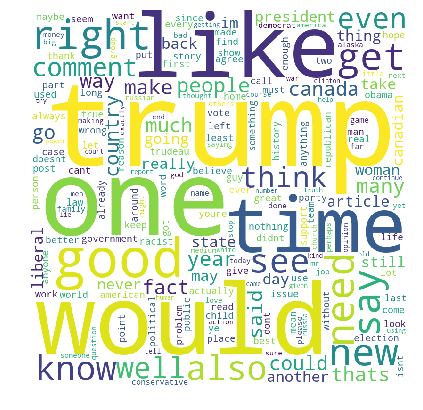

In [68]:
wordcloud = WordCloud(width = 800, height = 800, background_color ='white',  stopwords = stopwords, 
                    min_font_size = 10).generate(' '.join(pos)) 
# plot the WordCloud image                        
plt.figure(facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
plt.savefig('pos.jpg'.format(i))
plt.show() 

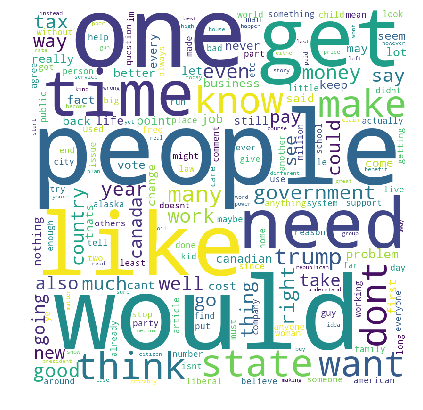

In [69]:
wordcloud = WordCloud(width = 800, height = 800, background_color ='white',  stopwords = stopwords, 
                    min_font_size = 10).generate(' '.join(neg)) 
# plot the WordCloud image                        
plt.figure(facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
plt.savefig('neg.jpg'.format(i))
plt.show() 

In [44]:
model = KMeans()
visualizer = KElbowVisualizer(model, k=(2,5))

In [45]:
visualizer.fit(sample)
visualizer.show() 

KeyboardInterrupt: 

In [47]:
distortions = [] 
inertias = [] 
mapping1 = {} 
mapping2 = {} 
K = range(1,10) 
  
for k in K: 
    #Building and fitting the model 
    print(k)
    kmeanModel = KMeans(n_clusters=k).fit(sample) 
    print('fitting')
    kmeanModel.fit(sample)     
    print('distortion')
    distortions.append(sum(np.min(cdist(sample, kmeanModel.cluster_centers_, 
                      'euclidean'),axis=1)) / sample.shape[0]) 
    print('inertia')
    inertias.append(kmeanModel.inertia_) 
    print('mapping')
    mapping1[k] = sum(np.min(cdist(sample, kmeanModel.cluster_centers_, 
                 'euclidean'),axis=1)) / sample.shape[0] 
    mapping2[k] = kmeanModel.inertia_ 

1
fitting
distortion


ValueError: XA must be a 2-dimensional array.